In [22]:
import os
import json
import time
from timeit import default_timer as timer
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pose_visualisation as vis
import reader, helpers
import torch, torch.nn
import scipy
%matplotlib inline
torch.set_default_dtype(torch.double)

In [23]:
def camera_generator(u, consts):
    """Generate camera parameters from (log-)normal model."""
    if u.dim() ==1:
        u = u.unsqueeze(0).detach()
    cam_foc = torch.ones_like(u[:, 0]) * consts['cam_foc']
    cam_pos = torch.concatenate([
        consts['cam_pos_x_mean'] + consts['cam_pos_x_std'] * u[:, 0:1],
        consts['cam_pos_y_mean'] + consts['cam_pos_y_std'] * u[:, 1:2],
        torch.exp(consts['log_cam_pos_z_mean'] +
               consts['log_cam_pos_z_std'] * u[:, 2:3])
    ], 1)
    cam_ang = torch.ones_like(u[:, :3]) * consts['cam_ang']
    return cam_foc, cam_pos, cam_ang

In [24]:
def camera_matrix_batch(focal_length, position, yaw_pitch_roll):
    """Get projective camera matrix given pose and focal length (batch)."""
    if position.ndim == 2:
        n_batch = position.shape[0]
    else:
        n_batch = 1
        focal_length = focal_length.reshape((1,))
        position = position[None, :]
        yaw_pitch_roll = yaw_pitch_roll[None, :]
    cam_mtx = torch.zeros((n_batch, 3, 4))
    rot_mtx = rot_z_batch(yaw_pitch_roll[:, 2])
    rot_mtx = torch.bmm(
        rot_mtx, rot_x_batch(yaw_pitch_roll[:, 1]))
    rot_mtx = torch.bmm(
        rot_mtx, rot_y_batch(yaw_pitch_roll[:, 0]))
    cam_mtx[:, :, :3]= rot_mtx
    cam_mtx[:, :, 3]= position
    int_mtx = torch.stack([focal_length, focal_length,
                        torch.ones_like(focal_length)])
    cam_mtx = (int_mtx * cam_mtx.T).T
    return cam_mtx


In [25]:
def rot_x(ang):
    """Returns matrix which defines rotation by `ang` about x-axis (0-axis)."""
    s = torch.sin(ang)
    c = torch.cos(ang)
    return torch.tensor([
        1, 0, 0,
        0, c, -s,
        0, s, c,
    ]).reshape((3, 3))


def rot_y(ang):
    """Returns matrix which defines rotation by `ang` about y-axis (1-axis)."""
    s = torch.sin(ang)
    c = torch.cos(ang)
    return torch.tensor([
        c, 0, s,
        0, 1, 0,
        -s, 0, c,
    ]).reshape((3, 3))


def rot_z(ang):
    """Returns matrix which defines rotation by `ang` about z-axis (2-axis)."""
    s = torch.sin(ang)
    c = torch.cos(ang)
    return torch.tensor([
        c, -s, 0,
        s, c, 0,
        0, 0, 1,
    ]).reshape((3, 3))


def rot_x_batch(ang):
    """Returns batch of matrices which defines rotations about x-axis (0)."""
    s = torch.sin(ang)
    c = torch.cos(ang)
    rot = torch.eye(3).unsqueeze(0).repeat(ang.shape[0], 1, 1)
    rot[:, 1, 1]=c
    rot[:, 1, 2]= -s
    rot[:, 2, 1]= s
    rot[:, 2, 2]= c
    return rot


def rot_y_batch(ang):
    """Returns batch of matrices which defines rotations about y-axis (1)."""
    s = torch.sin(ang)
    c = torch.cos(ang)
    rot = torch.eye(3).unsqueeze(0).repeat(ang.shape[0], 1, 1)
    rot[:, 0, 0]= c
    rot[:, 0, 2]= s
    rot[:, 2, 0]= -s
    rot[:, 2, 2]= c
    return rot


def rot_z_batch(ang):
    """Returns batch of matrices which defines rotations about z-axis (2)."""
    s = torch.sin(ang)
    c = torch.cos(ang)
    rot = torch.eye(3).unsqueeze(0).repeat(ang.shape[0], 1, 1)
    rot[:, 0, 0]= c
    rot[:, 0, 1]= -s
    rot[:, 1, 0]=s
    rot[:, 1, 1]=c
    return rot


rotation_map = {
    'Xrotation': rot_x,
    'Yrotation': rot_y,
    'Zrotation': rot_z
}
rotation_map_batch = {
    'Xrotation': rot_x_batch,
    'Yrotation': rot_y_batch,
    'Zrotation': rot_z_batch
}

In [26]:
consts = {
    'seed': 1234,
    'n_joint': 19,
    'n_joint_angle': 47,
    'n_joint_angle_latent': 30,
    'n_bone_length_input': 13,
    'n_camera_input': 3,
    'output_noise_std': 0.001,
    'cam_foc': np.exp(2.),
    'cam_pos_x_mean': 0.,
    'cam_pos_y_mean': 0.,
    'cam_pos_x_std': 0.1,
    'cam_pos_y_std': 0.1,
    'log_cam_pos_z_mean': 1.5,
    'log_cam_pos_z_std': 0.5,
    'cam_ang': torch.tensor(np.array([np.pi, 0., 0.])),
    'cam_pos_offset': torch.tensor(np.array([0.5, 0., 0.])),
    'cam_ang_offset': torch.tensor(np.array([0.0, 0., 0.]))
}
consts['n_joint_angle_input'] = (
    consts['n_joint_angle_latent'] +
    consts['n_joint_angle'] * 2)

In [27]:
bvh_reader = reader.BvhReader('skeleton.bvh')
bvh_reader.read()
helpers.process_skeleton(bvh_reader.root)
consts['skeleton'] = bvh_reader.root

with open('fixed_angles.json', 'r') as f:
    consts['fixed_joint_angles'] = json.load(f)

In [28]:
with np.load('params.npz') as f:
    l = 1
    #print(f['W_{0}'.format(l)])
    print('W_{0}'.format(l))

W_1


In [29]:
with np.load('params.npz') as f:
    num_layers = 7
    consts['joint_angles_vae_decoder_layers'] = []
    for l in range(num_layers):
        weight = torch.tensor(f['W_{0}'.format(l)])
        bias = torch.tensor(f['b_{0}'.format(l)])

        linear_layer = torch.nn.Linear(weight.size(0), weight.size(1))
        linear_layer.weight.data = weight
        linear_layer.bias.data = bias
        if l != num_layers - 1:
            nonlinearity = torch.nn.Tanh()
        else:
            nonlinearity = torch.nn.Identity()
        consts['joint_angles_vae_decoder_layers'].append({
            'linear_layer': linear_layer,
            'nonlinearity': nonlinearity })

In [30]:
consts['joints_to_skip'] = [
    'hips',
    'leftshoulder',
    'rightshoulder',
    'lefthandthumb1',
    'righthandthumb1',
    'lefthandthumb1endsite',
    'righthandthumb1endsite',
    'lefttoebaseendsite',
    'righttoebaseendsite'
]
lengths_model_params = np.load('params2.npz')
consts['log_lengths_covar'] = torch.tensor(lengths_model_params['covar'])
consts['log_lengths_covar_chol'] = torch.tensor(la.cholesky(lengths_model_params['covar']))
consts['log_lengths_mean'] = torch.tensor(lengths_model_params['mean'])

In [31]:
with open('lengths_order.json', 'r') as f:
    lengths_order = json.load(f)
    consts['bone_lengths_map'] = {
    node_name: lengths_order[length_name]
    for node_name, length_name
    in helpers.bone_lengths_map.items()
    if node_name not in ['lefthandthumb1endsite', 'righthandthumb1endsite']
}

In [32]:
rng = np.random.RandomState(consts['seed'])

In [33]:
n_noise = consts['n_joint'] * 4
n_in_dim = (
    consts['n_camera_input'] +
    consts['n_bone_length_input'] +
    consts['n_joint_angle_input'] +
    4 * consts['n_joint']
)

In [34]:
# this bit does some weird thing where it pre-calls the function, nothing is actually being generated yet since u is just some constant
# u = tt.matrix('u')
# y_bin = pose.noisy_binocular_2d_proj_generator(u, consts)
# y_3d = pose.joint_3d_pos_generator(u, consts)
# generator_binocular = th.function([u], y_bin)
# generator_3d = th.function([u], y_3d)

In [35]:
def partition(inputs, lengths):
    """Partition a one/two-dimesional tensor in to parts along last axis."""
    i = 0
    parts = []
    for l in lengths:
        parts.append(inputs.T[i:i+l].T)
        i += l
    return parts

In [36]:
def bone_lengths_generator(u, consts):
    """Generate skeleton bone lengths from log-normal model."""
    return torch.exp(consts['log_lengths_mean'] +
                  (u @ consts['log_lengths_covar_chol']))

def joint_angles_cos_sin_vae_decoder(h, layers, n_joint_angle):
    h = layers[0]['nonlinearity'](
        (h @ layers[0]['linear_layer'].weight.data) + layers[0]['linear_layer'].bias.data)
    # intermediate layers with skip-connections
    for layer in layers[1:-1]:
        h = layer['nonlinearity'](
            (h@layer['linear_layer'].weight.data) + layer['linear_layer'].bias.data) + h
    h = layers[-1]['nonlinearity'](
    (h@layers[-1]['linear_layer'].weight.data) + layers[-1]['linear_layer'].bias.data)
    print(h.size())
    if h.dim() == 1:
        h =h.unsqueeze(0).detach()
    print(h.size())
    return h[:, :n_joint_angle * 2], torch.exp(0.5 * h[:, n_joint_angle * 2:])


def joint_angles_generator(u, consts):
    """Generate joint angles from VAE decoder model."""
    h, n = partition(u, [consts['n_joint_angle_latent'],
                         consts['n_joint_angle'] * 2])
    ang_cos_sin_mean, ang_cos_sin_std = joint_angles_cos_sin_vae_decoder(
        h, consts['joint_angles_vae_decoder_layers'], consts['n_joint_angle'])
    ang_cos_sin = ang_cos_sin_mean + ang_cos_sin_std * n
    return torch.arctan2(ang_cos_sin[:, consts['n_joint_angle']:],
                      ang_cos_sin[:, :consts['n_joint_angle']])

In [37]:
def joint_positions(node, angles, fixed_angles=None, lengths=None,
                    lengths_map=None, skip=[], i=None, parent_trans=None):
    """Get list of joint pos. given skeleton tree and joint angles."""
    if i is None:
        i = [0]
    if parent_trans is None:
        parent_trans = torch.eye(4)
    joints = []
    rot = torch.eye(3)
    for ch in node.channels:
        ch_key = node.name.lower() + '_' + ch[0].lower()
        if ch in rotation_map:
            if fixed_angles is not None and ch_key in fixed_angles:
                rot = (rot@rotation_map[ch](torch.tensor(fixed_angles[ch_key])))
            else:
                rot = (rot@ rotation_map[ch](torch.tensor(angles[i[0]])))
                i[0] += 1
    local_trans = torch.eye(4)
    local_trans[:3, :3] = rot
    if not (node.name.lower() in skip and node.is_end_site):
        if lengths is None or node.length == 0.:
            node_offset = torch.tensor(np.array(node.offset))
        else:
            length = lengths[lengths_map[node.name.lower()]]
            node_offset = (torch.tensor(node.offset_unit) * length)
        local_trans[:3, 3] = torhc.tensor(node_offset)
        node_trans = parent_trans.dot(local_trans)
        if not node.name.lower() in skip:
            joints.append(node_trans[:, 3])
        for child in node.children:
            joints += joint_positions(child, angles, fixed_angles, lengths,
                                      lengths_map, skip, i, node_trans)
    return joints

In [38]:
def joint_positions_batch(
        node, angles, fixed_angles=None, lengths=None,
        lengths_map=None, skip=[], i=None, parent_trans=None):
    """Get list of joint pos. given skeleton tree and joint angles (batch)."""
    # check whether single vector of angles or mini-batch matrix provided
    if angles.ndim == 2:
        n_batch = angles.shape[0]
    elif angles.ndim == 1:
        n_batch = 1
        angles = angles[None, :]
        if lengths is not None and lengths.ndim == 1:
            lengths = lengths[None, :]
    else:
        raise Exception('angles should be one or two dimensional.')
    if i is None:
        i = [0]
    if parent_trans is None:
        parent_trans = torch.eye(4).unsqueeze(0).repeat(n_batch, 1, 1)
    joints = []
    rot = torch.eye(3).unsqueeze(0).repeat(n_batch, 1, 1)
    for ch in node.channels:
        ch_key = node.name.lower() + '_' + ch[0].lower()
        if ch in rotation_map:
            if fixed_angles is not None and ch_key in fixed_angles:
                rot = rot@(rotation_map[ch](torch.tensor(fixed_angles[ch_key])))
            else:
                rot = torch.bmm(
                    rot, rotation_map_batch[ch](torch.tensor(angles[:, i[0]])))
                i[0] += 1
    local_trans = torch.eye(4).unsqueeze(0).repeat(n_batch, 1, 1)
    local_trans[:, :3, :3] =  rot
    if not (node.name.lower() in skip and node.is_end_site):
        if lengths is None or node.length == 0.:
            node_offset = np.array(node.offset)[None, :]
        else:
            if lengths.dim() == 1:
                lengths = lengths.unsqueeze(0).detach()
            length = lengths[:, lengths_map[node.name.lower()]]
            node_offset = (torch.tensor(node.offset_unit[None, :]) *
                           length[:, None])
        local_trans[:, :3, 3]= torch.tensor(node_offset)
        node_trans = torch.bmm(parent_trans, local_trans)
        if not node.name.lower() in skip:
            joints.append(node_trans[:, :, 3])
        for child in node.children:
            joints += joint_positions_batch(
                child, angles, fixed_angles, lengths,
                lengths_map, skip, i, node_trans)
    return joints


In [39]:
def joint_3d_pos_generator(u, consts):
    """Generate 3D joint positions.

    Generates bone lengths and joint angles from respective models then uses
    skeleton definition to convert to 3D joint positions in global coordinate
    system.
    """
    input_sizes = [consts['n_bone_length_input'],
                   consts['n_joint_angle_input']]
    u_len, u_ang = partition(u, input_sizes)
    bone_lengths = bone_lengths_generator(u_len, consts)
    joint_angles = joint_angles_generator(u_ang, consts)
    print("SHAPE",torch.stack(joint_positions_batch(
        consts['skeleton'], joint_angles, consts['fixed_joint_angles'],
        lengths=bone_lengths, lengths_map=consts['bone_lengths_map'],
        skip=consts['joints_to_skip']), 2).size())
    return torch.stack(joint_positions_batch(
        consts['skeleton'], joint_angles, consts['fixed_joint_angles'],
        lengths=bone_lengths, lengths_map=consts['bone_lengths_map'],
        skip=consts['joints_to_skip']), 2)

In [40]:
def binocular_2d_proj_generator(u, consts):
    """Generate binocular 2D joint position projections.

    Generates bone lengths and joint angles from respective models then uses
    skeleton definition to convert to 3D joint positions in global coordinate
    system, before projecting to two sets of 2D image coordinates using two
    offset generated camera models.
    """
    n_batch = 1
    input_sizes = [consts['n_bone_length_input'] +
                   consts['n_joint_angle_input'],
                   consts['n_camera_input']]
    u_ske, u_cam, = partition(u, input_sizes)
    joint_pos_3d = joint_3d_pos_generator(u_ske, consts)
    cam_foc, cam_pos, cam_ang = camera_generator(u_cam, consts)
    cam_mtx_1 = camera_matrix_batch(
        cam_foc, cam_pos + consts['cam_pos_offset'],
        cam_ang + consts['cam_ang_offset'])
    cam_mtx_2 = camera_matrix_batch(
        cam_foc, cam_pos - consts['cam_pos_offset'],
        cam_ang - consts['cam_ang_offset'])
    joint_pos_2d_hom_1 = torch.bmm(cam_mtx_1, joint_pos_3d)
    joint_pos_2d_1 = (joint_pos_2d_hom_1[:, :2] /
                      joint_pos_2d_hom_1[:, 2][:, None, :])
    joint_pos_2d_hom_2 = torch.bmm(cam_mtx_2, joint_pos_3d)
    joint_pos_2d_2 = (joint_pos_2d_hom_2[:, :2] /
                      joint_pos_2d_hom_2[:, 2][:, None, :])

    print(f"First element: {joint_pos_2d_1.reshape((n_batch, -1)).size()} \n Second Element: {joint_pos_2d_2.reshape((n_batch, -1)).size()}")
    return torch.concatenate(
               [joint_pos_2d_1.reshape((n_batch, -1)),
                joint_pos_2d_2.reshape((n_batch, -1))], 1)



In [41]:
def noisy_binocular_2d_proj_generator(u, consts):
    """Generate noisy binocular 2D joint position projections.

    Generates bone lengths and joint angles from respective models then uses
    skeleton definition to convert to 3D joint positions in global coordinate
    system, before projecting to two sets of 2D image coordinates using two
    offset generated camera models and adding Gaussian observation noise to
    projections.
    """
    input_sizes = [consts['n_bone_length_input'] +
                   consts['n_joint_angle_input'] +
                   consts['n_camera_input'],
                   consts['n_joint'] * 4]
    u_pos, u_noi = partition(u, input_sizes)
    return (binocular_2d_proj_generator(u_pos, consts) +
            consts['output_noise_std'] * u_noi)

## "Observed" Data

In [42]:
n_data = 1
rng.seed(consts['seed'])
u_data = torch.tensor(rng.normal(size=(n_data, n_in_dim)))
y_data = noisy_binocular_2d_proj_generator(u_data, consts)
y_data_3d = joint_3d_pos_generator(u_data, consts)
np.savez('observed-data.npz',u_data=u_data, y_data=y_data, y_data_3d=y_data_3d)

torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
First element: torch.Size([1, 38]) 
 Second Element: torch.Size([1, 38])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])


C:\Users\Administrator\AppData\Local\Temp\ipykernel_8024\795312297.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rot, rotation_map_batch[ch](torch.tensor(angles[:, i[0]])))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_8024\795312297.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  local_trans[:, :3, 3]= torch.tensor(node_offset)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_8024\959262985.py:20: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensi

In [55]:
y_data_3d[:,0:3,:].squeeze().size()

torch.Size([3, 19])

## Generating a ton of these

In [ ]:
train_dataset
for i in range(1000):
    n_data = 1
    rng.seed(consts['seed'])
    u_data = torch.tensor(rng.normal(size=(n_data, n_in_dim)))
    y_data = noisy_binocular_2d_proj_generator(u_data, consts)
    y_data_3d = joint_3d_pos_generator(u_data, consts)
    points_3d = y_data_3d[:,0:3,:].squeeze().T
    train_dataset.append(points_3d)

torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
First element: torch.Size([1, 38]) 
 Second Element: torch.Size([1, 38])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
First element: torch.Size([1, 38]) 
 Second Element: torch.Size([1, 38])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
First element: torch.Size([1, 38]) 
 Second Element: torch.Size([1, 38])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
First element: torch.Size([1, 38]) 
 Second Element: torch.Size([1, 38])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
First element: torch.Size([1, 38]) 
 Second Element: torch.Size([1, 3

C:\Users\Administrator\AppData\Local\Temp\ipykernel_8024\795312297.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rot, rotation_map_batch[ch](torch.tensor(angles[:, i[0]])))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_8024\795312297.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  local_trans[:, :3, 3]= torch.tensor(node_offset)


First element: torch.Size([1, 38]) 
 Second Element: torch.Size([1, 38])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
First element: torch.Size([1, 38]) 
 Second Element: torch.Size([1, 38])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
First element: torch.Size([1, 38]) 
 Second Element: torch.Size([1, 38])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
First element: torch.Size([1, 38]) 
 Second Element: torch.Size([1, 38])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
First element: torch.Size([1, 38]) 
 Second Element: torch.Size([1, 38])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 1

KeyboardInterrupt: 

In [50]:
y_data_3d[:,3]

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1.]])

In [46]:
y_data

tensor([[ 0.6294,  0.6077,  0.5741,  0.4563,  0.3452,  0.2778,  0.2758,  0.7277,
          0.9534,  0.8401,  0.8340,  0.5367,  0.5294,  0.5269,  0.4793,  0.7115,
          0.6978,  0.6900,  0.7356,  0.0110,  0.4183,  0.5171,  0.2979,  0.0126,
         -0.2238, -0.3245,  0.4096,  0.5622,  0.7867,  0.8944, -0.1524, -0.5717,
         -0.9724, -1.0295, -0.1600, -0.5795, -0.9678, -1.0415, -0.2740, -0.2883,
         -0.3266, -0.4333, -0.5441, -0.6162, -0.6206, -0.1732,  0.0304, -0.0937,
         -0.0999, -0.3625, -0.3652, -0.3659, -0.4340, -0.1918, -0.1983, -0.2008,
         -0.1730,  0.0115,  0.4180,  0.5168,  0.2979,  0.0129, -0.2228, -0.3253,
          0.4100,  0.5612,  0.7852,  0.8934, -0.1504, -0.5703, -0.9710, -1.0288,
         -0.1591, -0.5772, -0.9685, -1.0406]])

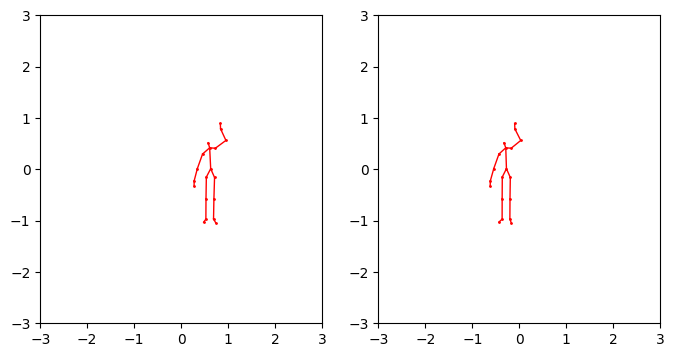

In [22]:
for bin_proj in y_data:
    joints_1, joints_2 = bin_proj.reshape((2, 2, -1))
    fig, ax1, ax2 = vis.plot_binocular_projections(
        joints_1.T, joints_2.T, fig_size=(8, 4))
    ax1.axis([-3, 3, -3, 3])
    ax2.axis([-3, 3, -3, 3])

## Constrained HMC

In [23]:
def gaussian_energy(u):
    """Negative log of density independent standard normal variables."""
    return 0.5 * torch.dot(u,u)

In [24]:
def force(u):
    return jacobian(force,u)

In [25]:
def constraint(u,y):
    return binocular_2d_proj_generator(u, consts) - y

In [26]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from sympy import Matrix, Array
from sympy.abc import x, y, z
import torch
from torch.autograd.functional import jacobian
import matplotlib.pyplot as plt

from matplotlib.collections import LineCollection
import matplotlib.colors as colors
import cProfile
import pstats


def G(gs):
    '''
    :param gs: a list of tensor functions
    :return: a function sending a tensor to the stacked matrix of the functions of that tensor
    '''

    def G_gs(tensor):
        # print("Function input: ",tensor) # checking the input for debugging
        # print("Function output:" , torch.stack([g(tensor) for g in gs],0))
        return torch.stack([g(tensor) for g in gs], 0)

    return G_gs

def J(gs, x):
    '''Returns the Jacobian evaluated at x for a list gs of constraint functions'''
    return jacobian(G(gs), x)

def rattle_step(x, v1, h, M, gs, e , lamb):
    '''
    Defining a function to take a step in the position, velocity form.
    g should be a vector-valued function of constraints.
    :return: x_1, v_1
    '''

    M1 =  torch.inverse(M)

    G1 = G(gs)


    DV = torch.zeros_like(x)

    #DV[-1] = 10  # leaving this out for g-BAOAB
    DV_col = DV.reshape(-1, 1)

    x_col = x.reshape(-1, 1)
    v1_col = v1.reshape(-1, 1)

    # doing Newton-Raphson iterations
    lam = lamb
    iters = 0
    x2 = x_col + h * v1_col - 0.5*(h**2)* M1 @ DV_col
    Q_col = x2
    Q = torch.squeeze(Q_col)
    J1 = J(gs, torch.squeeze(x_col))


    while iters <8:
        J2 = J(gs, torch.squeeze(Q))
        R = J2 @ M1 @ J1.t()
        dL = torch.inverse(R) @ G1(Q)
        #print(f"Q = {Q}")
        Q -= M1 @ J1.t() @ dL
        iters +=1

    # half step for velocity
    Q_col = Q.reshape(-1,1)
    v1_half = (Q_col - x_col)/h
    x_col = Q_col
    J1 = J(gs, torch.squeeze(x_col))

    # getting the level
    J2 = J(gs, torch.squeeze(Q))
    P = J1 @ M1 @ J1.t()
    T = J1 @ (2/h * v1_half - M1 @ DV_col)

    #solving the linear system
    L = torch.linalg.solve(P,T)

    v1_col = v1_half - h/2 * DV_col - h/2 * J2.t()@L


    # print(f"Error = {G1(x_col + h*( v1_col + h/2 * torch.inverse(M) @ J1.reshape(-1,1) @ lam))}")
    # # updating v
    # print(f"lam = {lam}")
    # print(f"Updating v1_col, Jacobian^T {J(gs,torch.squeeze(x_col)).t}")

    return torch.squeeze(x_col), torch.squeeze(v1_col)

def rattle_simulator(x_init, v_init, h, M, gs, its):
    xs = [x_init]
    vs = [v_init]
    F = torch.tensor([0.,-10.])
    energy = 1/2 * torch.dot(torch.squeeze(v_init), torch.squeeze(v_init)) + torch.dot(torch.squeeze(x_init), F)
    energies = [energy]
    x = x_init
    v1 = v_init
    for i in range(its):
        x, v1 = rattle_step(x, v1, h, M, gs, 10 ** (-8), torch.zeros(len(gs)))
        energy = 1/2 * torch.dot(v1,v1) + torch.dot(x, -F)
        xs.append(x)
        vs.append(v1)
        energies.append(energy)
    return xs, vs, energies

def gBAOAB_step_exact(q_init,p_init,F, GO, h,M, gamma, k):

    # setting up variables
    M1 = torch.inverse(M)
    R = torch.randn(len(q_init))
    p = p_init
    q = q_init
    a2 = torch.exp(torch.tensor(-gamma*h))
    b2 = torch.sqrt(k*(1-a2**(2)))

    # doing the initial p-update
    J1 = jacobian(GO,torch.squeeze(q))
    G = torch.squeeze(J1)
    print(f"Jacobian {G}")
    print(f"Jacobian shape {G.size()}, M1 shape = {M1.size()}")
    P = (G@ M1@ torch.transpose(G,0,1))



    L1 = torch.eye(len(q_init)) - torch.transpose(G,0,1) @  torch.inverse(G@ M1@ torch.transpose(G,0,1)) @ G @ M1

    p -=  h/2 * L1 @ F(q)


    # doing the first RATTLE step
    q, p = rattle_step(q, p, h/2, M, gs, 10**(-2) , torch.zeros(len(q)))


    # the second p-update - (O-step in BAOAB)
    J2 = jacobian(GO,torch.squeeze(q))
    G = J2
    L2 = torch.eye(len(q_init)) - torch.transpose(G,0,1) @ torch.inverse(G@ M1@ torch.transpose(G,0,1)) @ G @ M1
    p = a2* p + b2* M**(1/2) @L2 @ M**(1/2) @ R

    # doing the second RATTLE step
    q, p = rattle_step(q, p, h/2, M, gs, 10**(-2) , torch.zeros(len(q)))


    # the final p update
    J3= jacobian(GO,torch.squeeze(q))
    G = J3
    L3 = torch.eye(len(q_init)) - torch.transpose(G,0,1) @  torch.inverse(G@ M1@ torch.transpose(G,0,1)) @ G @ M1
    p -=  h/2 * L3 @ F(q)

    return q,p

def gBAOAB_integrator(q_init,p_init,F, gs, h,M, gamma, k, steps):
    positions = []
    velocities = []
    q = q_init
    p = p_init
    for i in range(steps):
        q, p = gBAOAB_step_exact(q,p, F,gs, h,M, gamma, k)
        positions.append(q)
        velocities.append(p)

    return positions, velocities

In [27]:

h = 0.0001
its = 0
for d, y, y_3d in zip(range(n_data), y_data, y_data_3d):
    its += 1
    print(its)
    gs = lambda u : constraint(u,y)
    u_init = torch.zeros(n_in_dim)
    y_init = binocular_2d_proj_generator(u_init, consts)
    u_init[-n_noise:] = (y - y_init) / consts['output_noise_std']
    u_samples, p_samples = gBAOAB_integrator(u_init,y_init,force, gs, h,torch.eye(len(u_init)), 1, 1, 200)

1
torch.Size([188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
First element: torch.Size([1, 38]) 
 Second Element: torch.Size([1, 38])
torch.Size([188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
First element: torch.Size([1, 38]) 
 Second Element: torch.Size([1, 38])
Jacobian tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Jacobian shape torch.Size([76, 216]), M1 shape = torch.Size([216, 216])


C:\Users\Administrator\AppData\Local\Temp\ipykernel_18536\795312297.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rot, rotation_map_batch[ch](torch.tensor(angles[:, i[0]])))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_18536\795312297.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  local_trans[:, :3, 3]= torch.tensor(node_offset)


_LinAlgError: linalg.inv: The diagonal element 1 is zero, the inversion could not be completed because the input matrix is singular.